# Decision Tree and Random Forest Classifier to predict movie genre 


In [1]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [2]:
# Loading dataset
movie_data = pd.read_csv("output.csv")
movie_data.head()

,movie_name,genres
0,Miss Jerry,['romance']
1,Hamlet,['drama']
2,The Fairylogue and Radio-Plays,"['adventure', 'fantasy']"
3,"Hamlet, Prince of Denmark",['drama']
4,The Life of Moses,"['biography', 'drama', 'family']"


In [3]:
# describing features of dataset
movie_data.describe()

,movie_name,genres
count,199280,199280
unique,173598,1270
top,Broken,['drama']
freq,27,31490


### Converting genres in list 

Calculating the total number of genres in the dataset and converting them into list by appending a new column in 
existing dataset with is **'new_genre'**

In [4]:
# Calculate the total number of genres in the dataset and converting them into list by making a new column in 
# existing dataset with is 'new_genre'
totalGenres = []
allGenres = []
for row in movie_data['genres']:
    if row:
        temp = []
        curstr = row[1:-1]
        curGenres = curstr.split(',')
        for eachGenre in curGenres:
            allGenres.append(eachGenre.strip())
            temp.append(eachGenre.strip())
        totalGenres.append(temp)
movie_data['new_genres'] = totalGenres

movie_data.head()


,movie_name,genres,new_genres
0,Miss Jerry,['romance'],['romance']
1,Hamlet,['drama'],['drama']
2,The Fairylogue and Radio-Plays,"['adventure', 'fantasy']","['adventure', 'fantasy']"
3,"Hamlet, Prince of Denmark",['drama'],['drama']
4,The Life of Moses,"['biography', 'drama', 'family']","['biography', 'drama', 'family']"


#### using FreqDist() method
FreqDist accepts a list of words and returns an object that contains the map word and its respective frequency in the input word list.

In [5]:
# nltk(natural language processing toolkit) method freqdist
allGenres = nltk.FreqDist(allGenres) 
allGenres

FreqDist({"'drama'": 76195, "'comedy'": 42548, "'documentary'": 35089, "'action'": 22183, "'thriller'": 20270, "'horror'": 18973, "'romance'": 16858, "'crime'": 15670, "'adventure'": 13474, "'sci-fi'": 7766, ...})

In [6]:
all_genres_df = pd.DataFrame({'Genre': list(allGenres.keys()), 
                              'Count': list(allGenres.values())})
all_genres_df

,Genre,Count
0,'romance',16858
1,'drama',76195
2,'adventure',13474
3,'fantasy',6131
4,'biography',7244
5,'family',6196
6,'war',3272
7,'history',5320
8,'documentary',35089
9,'western',5960


### Word Cloud for different genres of the movies

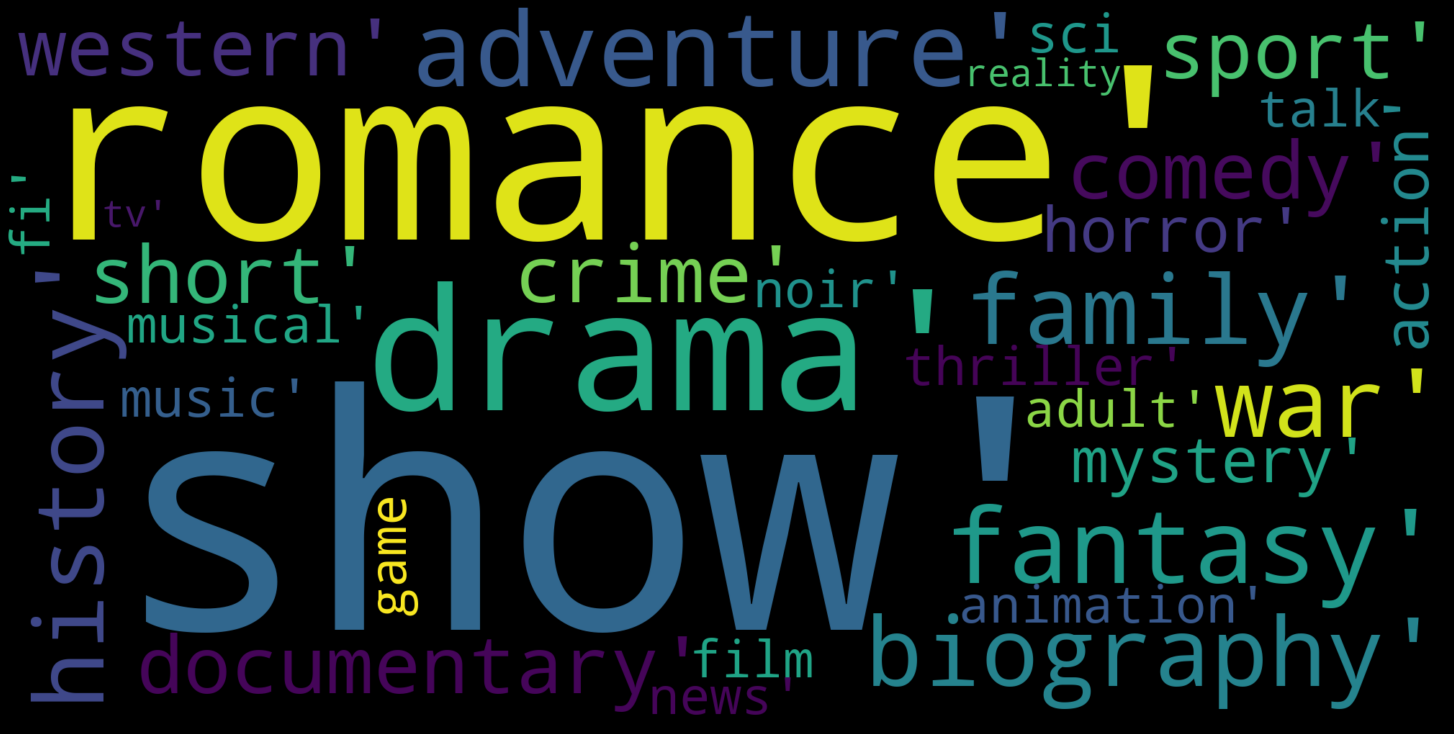

In [7]:
import matplotlib.pyplot as plt
text = all_genres_df.Genre.values
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (20, 15),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

There are 28 genres in total 

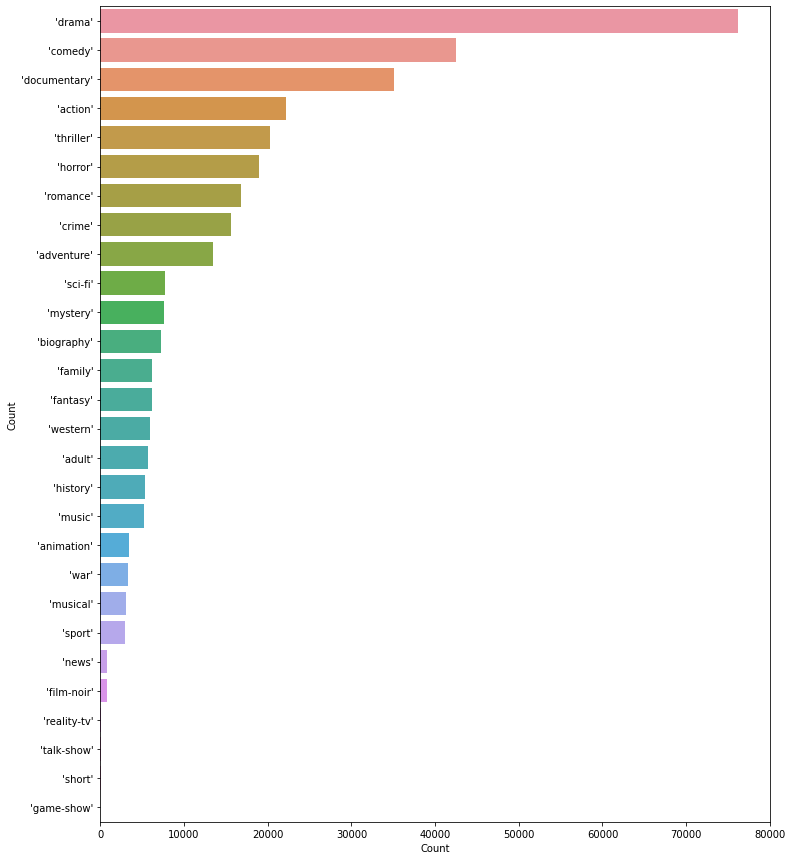

In [8]:
# Visualizing count of a particular genre
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

#### Stopwords removal
Looking for stopwords from the nltk library and then writing method to remove stopwords from the text

In [9]:
# function to remove stopwords
stop_words = set(stopwords.words('english'))


def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

#### Defining methods to clean the text

Using tokenization(convert from string to list), stemming(remove -ing, -ly, ...) and lemmatization(convert the word into root word)

In [10]:
'''
Preprocess a string text input.
:parameter
    :parameter text: - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def func_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize 
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming 
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation 
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

#### appending a new column with clean movie_name text

In [11]:
movie_data['movie_name_new'] = movie_data['movie_name'].apply(lambda x: func_preprocess_text(x))

In [12]:
movie_data.head()

,movie_name,genres,new_genres,movie_name_new
0,Miss Jerry,['romance'],['romance'],miss jerry
1,Hamlet,['drama'],['drama'],hamlet
2,The Fairylogue and Radio-Plays,"['adventure', 'fantasy']","['adventure', 'fantasy']",the fairylogue and radioplays
3,"Hamlet, Prince of Denmark",['drama'],['drama'],hamlet prince of denmark
4,The Life of Moses,"['biography', 'drama', 'family']","['biography', 'drama', 'family']",the life of moses


### Dropping redundant columns genres and movie_name

In [13]:
df= movie_data.drop(['genres', 'movie_name'], axis=1)

In [14]:
df.head()

,new_genres,movie_name_new
0,['romance'],miss jerry
1,['drama'],hamlet
2,"['adventure', 'fantasy']",the fairylogue and radioplays
3,['drama'],hamlet prince of denmark
4,"['biography', 'drama', 'family']",the life of moses


### renaming column name movie_name_new as movie_title and new_genres as genres

In [15]:
df = df.rename(columns={"movie_name_new": "movie_title", "new_genres": "genres"})
df.head()

,genres,movie_title
0,['romance'],miss jerry
1,['drama'],hamlet
2,"['adventure', 'fantasy']",the fairylogue and radioplays
3,['drama'],hamlet prince of denmark
4,"['biography', 'drama', 'family']",the life of moses


Once again cleaning the text by removing not relevant words

In [16]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [17]:
nltk.download('wordnet')
df["movie_title_clean"] = df["movie_title"].apply(lambda x: 
          func_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Piyusman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,genres,movie_title,movie_title_clean
0,['romance'],miss jerry,miss jerry
1,['drama'],hamlet,hamlet
2,"['adventure', 'fantasy']",the fairylogue and radioplays,fairylogue radioplays
3,['drama'],hamlet prince of denmark,hamlet prince denmark
4,"['biography', 'drama', 'family']",the life of moses,life moses


#### Multilabel Classification
For multilabel classification we need to use multilabel_binarizer method to convert our target into binary form which can be understand by the machine

In [18]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genres'])

# transform target variable
y = multilabel_binarizer.transform(df['genres'])

#### Train-Test Split (90% Training data & 10% Testing data)

In [19]:
xtrain, xval, ytrain, yval = train_test_split(df['movie_title_clean'], y, test_size=0.01)
print(ytrain.shape)
print(xtrain.shape)
print(xtrain)
print(ytrain)


(197287, 28)
(197287,)
42918                       storybook
131429              posthuman project
193221             importance earnest
49764                           dutch
105145                 next three day
                     ...             
46936                    happier ever
177306                  last prosecco
28907     michael kohlhaas der rebell
170892                      sepulcrum
19786                   cowboy indian
Name: movie_title_clean, Length: 197287, dtype: object
[[0 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 1]]


#### TFIDF method
TFIDF method evaluates how relevant a word is to a document in a collection of documents. 

In [20]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, max_df= 1.0,ngram_range=(1,2))

In [21]:
corpus = xtrain
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
dic_vocabulary

{'project': 7016,
 'importance': 4472,
 'earnest': 2845,
 'dutch': 2822,
 'next': 6204,
 'three': 8910,
 'day': 2339,
 'three day': 8911,
 'come': 1900,
 'female': 3260,
 'femme': 3263,
 'celluloid': 1589,
 'affair': 246,
 'word': 9855,
 'service': 7870,
 'sacrifice': 7619,
 'woman': 9830,
 'wood': 9849,
 'prisoner': 6993,
 'tower': 9056,
 'fire': 3330,
 'first': 3343,
 'name': 6097,
 'carmen': 1517,
 'head': 4107,
 'dont': 2679,
 'know': 4932,
 'doe': 2652,
 'dont know': 2687,
 'one': 6408,
 'night': 6222,
 'one night': 6424,
 'singularity': 8085,
 'principle': 6988,
 'specter': 8319,
 'old': 6385,
 'main': 5522,
 'white': 9732,
 'knuckle': 4937,
 'mysterious': 6083,
 'rider': 7402,
 'flag': 3375,
 'lead': 5071,
 'forward': 3477,
 'bitter': 989,
 'nowhere': 6316,
 'dry': 2791,
 'town': 9057,
 'suburbia': 8582,
 'nirvana': 6262,
 'parasite': 6585,
 'ufo': 9255,
 'past': 6620,
 'present': 6958,
 'future': 3584,
 'past present': 6622,
 'present future': 6959,
 'bowl': 1207,
 'dream': 274

In [22]:
word = "war"
dic_vocabulary[word]

9601

In [23]:
Xval_tfidf = vectorizer.transform(xval)

### Using decision tree for multilabel classification 

#### 5-fold Cross Validation Scores on training data

In [25]:
# cross_val_score(clf_DTpruned, X_train, ytrain, cv=5)

array([0.01469917, 0.01573825, 0.01330562, 0.01348303, 0.01259599])

In [24]:
#developing a model with Decision Tree Classifier
clf_DTpruned = DecisionTreeClassifier(criterion = "gini",max_depth=10, min_samples_leaf=2, random_state = 1000)
clf_DTpruned.fit(X_train, ytrain)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, random_state=1000)

In [26]:
y_pred_DT = clf_DTpruned.predict(Xval_tfidf)
y_pred_DT[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [27]:
multilabel_binarizer.inverse_transform(y_pred_DT)[1]

()

#### F1 Score for the prediction

In [28]:
# Evaluation of classifier
print("f1_Score_micro: ", f1_score(yval, y_pred_DT, average="micro"))
print("f1_score_weighted", f1_score(yval, y_pred_DT, average='weighted'))


f1_Score_micro:  0.023647650014779777
f1_score_weighted 0.02255415108497004


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


#### Classification Report

In [29]:
from sklearn import metrics

print("Classification Report: \n", metrics.classification_report(yval, y_pred_DT))

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       213
           1       0.00      0.00      0.00        56
           2       0.00      0.00      0.00       120
           3       0.00      0.00      0.00        37
           4       0.00      0.00      0.00        69
           5       0.00      0.00      0.00       404
           6       0.00      0.00      0.00       174
           7       0.55      0.06      0.11       373
           8       0.54      0.02      0.03       775
           9       0.00      0.00      0.00        60
          10       0.00      0.00      0.00        64
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00        49
          14       0.57      0.02      0.05       166
          15       0.00      0.00      0.00        50
          16       0.00      0.00      0.00        34
  

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Decision Tree
Got very poor results by using decision trees, model is suffering from underfit, so, instead of using decision tree, next will use Random Forest to classify movies based on the genre.

### Using Random Forest with 20 n_estimators to predict genre of the movie

#### 5-fold Cross Validation Scores on training data

In [32]:
# cross_val_score(classifier, X_train, ytrain, cv=5)

array([0.11303158, 0.11108014, 0.10913146, 0.11295841, 0.109613  ])

In [30]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'gini', 
                                    random_state = 42)


In [31]:
classifier.fit(X_train, ytrain)

RandomForestClassifier(n_estimators=20, random_state=42)

In [34]:
y_pred_RF = classifier.predict(Xval_tfidf)
y_pred_RF[4]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [35]:
multilabel_binarizer.inverse_transform(y_pred_RF)[4]

("'drama'",)

#### F1 Score for the prediction

In [36]:
print("f1_Score_micro: ", f1_score(yval, y_pred_RF, average="micro"))
print("f1_score_weighted", f1_score(yval, y_pred_RF, average='weighted'))

f1_Score_micro:  0.25384953805543337
f1_score_weighted 0.23529693491858228


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


#### Classification Report

In [37]:
print("Classification Report: \n", metrics.classification_report(yval, y_pred_RF))

Classification Report: 
               precision    recall  f1-score   support

           0       0.41      0.15      0.22       213
           1       0.46      0.11      0.17        56
           2       0.34      0.09      0.14       120
           3       0.80      0.11      0.19        37
           4       0.00      0.00      0.00        69
           5       0.44      0.18      0.26       404
           6       0.33      0.06      0.11       174
           7       0.56      0.22      0.32       373
           8       0.52      0.35      0.42       775
           9       0.33      0.03      0.06        60
          10       0.18      0.03      0.05        64
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         0
          13       0.09      0.02      0.03        49
          14       0.44      0.17      0.25       166
          15       0.17      0.04      0.06        50
          16       0.17      0.03      0.05        34
  

/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This is multiclass classification with imbalanced data

### Prediction of movie-genre using movie-title as an input

In [38]:
def doInference(q):
    q = func_preprocess_text(q)
    q = remove_stopwords(q)
    q_vec = vectorizer.transform([q])
    q_pred = classifier.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [39]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Movie: ", df['movie_title'][k], "\nPredicted genre: ", doInference(xval[k])), print("Actual genre: ",df['genres'][k], "\n")


Movie:  firefly 
Predicted genre:  [("'drama'",)]
Actual genre:  ["'drama'"] 

Movie:  his majesty bunker bean 
Predicted genre:  [("'comedy'",)]
Actual genre:  ["'comedy'"] 

Movie:  lover on the run the complete story of bonnie clyde 
Predicted genre:  [("'crime'",)]
Actual genre:  ["'crime'", "'history'"] 

Movie:  lentil soup 
Predicted genre:  [("'comedy'",)]
Actual genre:  ["'drama'"] 

Movie:  tex take a holiday 
Predicted genre:  [()]
Actual genre:  ["'western'"] 

